# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 1000            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 100, 300, 700]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/1000: Train Loss 0.7070 | Test Loss 0.6958 | accs Train 0.4500 Test 0.5000


[SAM] Epoch 100/1000: Train Loss 0.1558 | Test Loss 1.6014 | accs Train 0.9500 Test 0.5355


[SAM] Epoch 200/1000: Train Loss 0.0245 | Test Loss 3.0843 | accs Train 1.0000 Test 0.5387


[SAM] Epoch 300/1000: Train Loss 0.0046 | Test Loss 3.8543 | accs Train 1.0000 Test 0.5165


[SAM] Epoch 400/1000: Train Loss 0.0012 | Test Loss 4.5575 | accs Train 1.0000 Test 0.5160


[SAM] Epoch 500/1000: Train Loss 0.0004 | Test Loss 5.0322 | accs Train 1.0000 Test 0.5178


[SAM] Epoch 600/1000: Train Loss 0.0002 | Test Loss 5.2836 | accs Train 1.0000 Test 0.5172


[SAM] Epoch 700/1000: Train Loss 0.0001 | Test Loss 5.4744 | accs Train 1.0000 Test 0.5180


[SAM] Epoch 800/1000: Train Loss 0.0001 | Test Loss 5.6271 | accs Train 1.0000 Test 0.5190


[SAM] Epoch 900/1000: Train Loss 0.0001 | Test Loss 5.7594 | accs Train 1.0000 Test 0.5188


[SAM] Epoch 1000/1000: Train Loss 0.0001 | Test Loss 5.8790 | accs Train 1.0000 Test 0.5198
Completed training with 0 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.7141 | Test Loss 0.6957 | accs Train 0.4200 Test 0.5000


[SAM] Epoch 100/1000: Train Loss 0.4506 | Test Loss 0.7662 | accs Train 0.7800 Test 0.6105


[SAM] Epoch 200/1000: Train Loss 0.2827 | Test Loss 1.1199 | accs Train 0.8800 Test 0.6510


[SAM] Epoch 300/1000: Train Loss 0.1847 | Test Loss 1.3723 | accs Train 0.9600 Test 0.6685


[SAM] Epoch 400/1000: Train Loss 0.1239 | Test Loss 1.6169 | accs Train 0.9800 Test 0.6805


[SAM] Epoch 500/1000: Train Loss 0.0908 | Test Loss 1.7969 | accs Train 0.9600 Test 0.6930


[SAM] Epoch 600/1000: Train Loss 0.0678 | Test Loss 1.9301 | accs Train 0.9800 Test 0.7235


[SAM] Epoch 700/1000: Train Loss 0.0535 | Test Loss 2.1435 | accs Train 0.9800 Test 0.7308


[SAM] Epoch 800/1000: Train Loss 0.0420 | Test Loss 2.2643 | accs Train 1.0000 Test 0.7375


[SAM] Epoch 900/1000: Train Loss 0.0238 | Test Loss 2.5213 | accs Train 1.0000 Test 0.7482


[SAM] Epoch 1000/1000: Train Loss 0.0082 | Test Loss 2.9438 | accs Train 1.0000 Test 0.7538
Completed training with 30 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.7076 | Test Loss 0.6949 | accs Train 0.4583 Test 0.5000


[SAM] Epoch 100/1000: Train Loss 0.5276 | Test Loss 0.6117 | accs Train 0.7583 Test 0.6710


[SAM] Epoch 200/1000: Train Loss 0.3922 | Test Loss 0.5399 | accs Train 0.7917 Test 0.6763


[SAM] Epoch 300/1000: Train Loss 0.1681 | Test Loss 0.3273 | accs Train 0.9500 Test 0.8525


[SAM] Epoch 400/1000: Train Loss 0.0662 | Test Loss 0.1942 | accs Train 0.9833 Test 0.9257


[SAM] Epoch 500/1000: Train Loss 0.0266 | Test Loss 0.1372 | accs Train 1.0000 Test 0.9523


[SAM] Epoch 600/1000: Train Loss 0.0125 | Test Loss 0.1138 | accs Train 1.0000 Test 0.9567


[SAM] Epoch 700/1000: Train Loss 0.0078 | Test Loss 0.1053 | accs Train 1.0000 Test 0.9600


[SAM] Epoch 800/1000: Train Loss 0.0057 | Test Loss 0.0986 | accs Train 1.0000 Test 0.9627


[SAM] Epoch 900/1000: Train Loss 0.0043 | Test Loss 0.0962 | accs Train 1.0000 Test 0.9645


[SAM] Epoch 1000/1000: Train Loss 0.0036 | Test Loss 0.0888 | accs Train 1.0000 Test 0.9675
Completed training with 100 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.7026 | Test Loss 0.6948 | accs Train 0.4750 Test 0.5000


[SAM] Epoch 100/1000: Train Loss 0.5503 | Test Loss 0.5842 | accs Train 0.6781 Test 0.6710


[SAM] Epoch 200/1000: Train Loss 0.3690 | Test Loss 0.4198 | accs Train 0.8219 Test 0.7632


[SAM] Epoch 300/1000: Train Loss 0.1436 | Test Loss 0.1968 | accs Train 0.9656 Test 0.9353


[SAM] Epoch 400/1000: Train Loss 0.0308 | Test Loss 0.0692 | accs Train 1.0000 Test 0.9852


[SAM] Epoch 500/1000: Train Loss 0.0109 | Test Loss 0.0351 | accs Train 1.0000 Test 0.9925


[SAM] Epoch 600/1000: Train Loss 0.0070 | Test Loss 0.0324 | accs Train 1.0000 Test 0.9915


[SAM] Epoch 700/1000: Train Loss 0.0037 | Test Loss 0.0290 | accs Train 1.0000 Test 0.9928


[SAM] Epoch 800/1000: Train Loss 0.0038 | Test Loss 0.0240 | accs Train 1.0000 Test 0.9928


[SAM] Epoch 900/1000: Train Loss 0.0017 | Test Loss 0.0218 | accs Train 1.0000 Test 0.9928


[SAM] Epoch 1000/1000: Train Loss 0.0011 | Test Loss 0.0217 | accs Train 1.0000 Test 0.9930
Completed training with 300 additional samples of data
[SAM] Epoch 1/1000: Train Loss 0.6995 | Test Loss 0.6947 | accs Train 0.4861 Test 0.5000


[SAM] Epoch 100/1000: Train Loss 0.5655 | Test Loss 0.5817 | accs Train 0.6417 Test 0.6158


[SAM] Epoch 200/1000: Train Loss 0.3477 | Test Loss 0.3740 | accs Train 0.8486 Test 0.8195


[SAM] Epoch 300/1000: Train Loss 0.1394 | Test Loss 0.1571 | accs Train 0.9958 Test 0.9958


[SAM] Epoch 400/1000: Train Loss 0.0353 | Test Loss 0.0407 | accs Train 1.0000 Test 0.9992


[SAM] Epoch 500/1000: Train Loss 0.0103 | Test Loss 0.0130 | accs Train 1.0000 Test 0.9995


[SAM] Epoch 600/1000: Train Loss 0.0046 | Test Loss 0.0064 | accs Train 1.0000 Test 0.9992


[SAM] Epoch 700/1000: Train Loss 0.0072 | Test Loss 0.0097 | accs Train 1.0000 Test 0.9992


[SAM] Epoch 800/1000: Train Loss 0.0053 | Test Loss 0.0075 | accs Train 1.0000 Test 0.9988


[SAM] Epoch 900/1000: Train Loss 0.0033 | Test Loss 0.0051 | accs Train 1.0000 Test 0.9990


[SAM] Epoch 1000/1000: Train Loss 0.0022 | Test Loss 0.0038 | accs Train 1.0000 Test 0.9990
Completed training with 700 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 5.8790 | accs: 0.5198
  30 samples | Test Loss: 2.9438 | accs: 0.7538
 100 samples | Test Loss: 0.0888 | accs: 0.9675
 300 samples | Test Loss: 0.0217 | accs: 0.9930
 700 samples | Test Loss: 0.0038 | accs: 0.9990

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0001 | accs: 1.0000
 Model   30 | Train Loss: 0.0093 | accs: 1.0000
 Model  100 | Train Loss: 0.0008 | accs: 1.0000
 Model  300 | Train Loss: 0.0009 | accs: 1.0000
 Model  700 | Train Loss: 0.0014 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 4.4785 | accs: 0.6400
 Model   30 | Train Loss: 0.0081 | accs: 1.0000
 Model  100 | Train Loss: 0.0007 | accs: 1.0000
 Model  300 | Train Loss: 0.0008 | accs: 1.0000
 Model  700 | Train Loss: 0.0016 | accs: 1.0000

Dataset type: data, additional samples: 100
 Model    0 | Train Loss: 5.4822 | accs: 0.5750
 Model   30 | Train Loss: 1.

### Model + Data Specific Verification

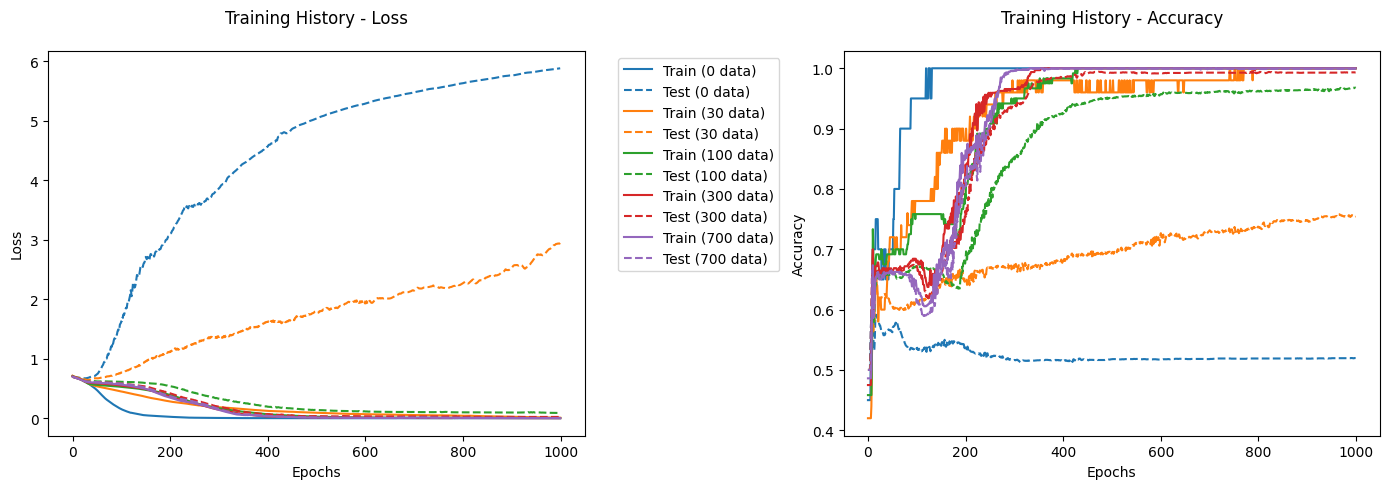

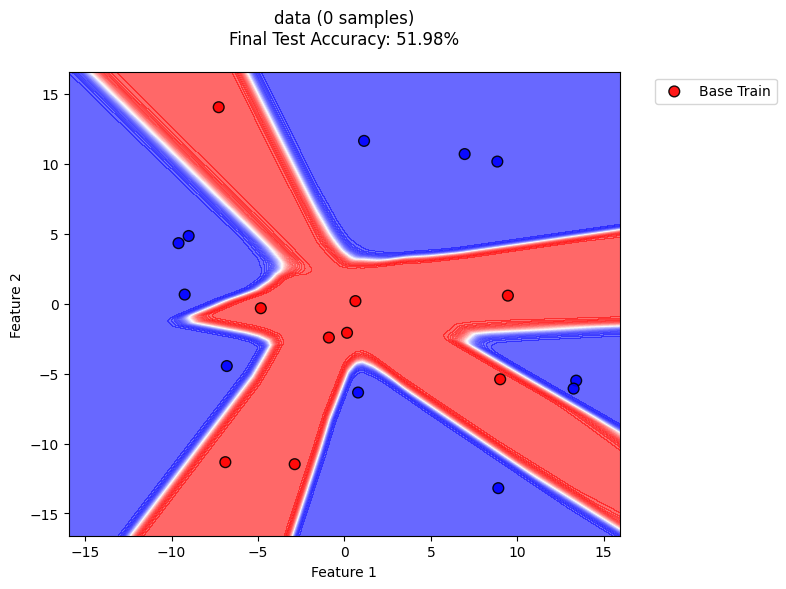

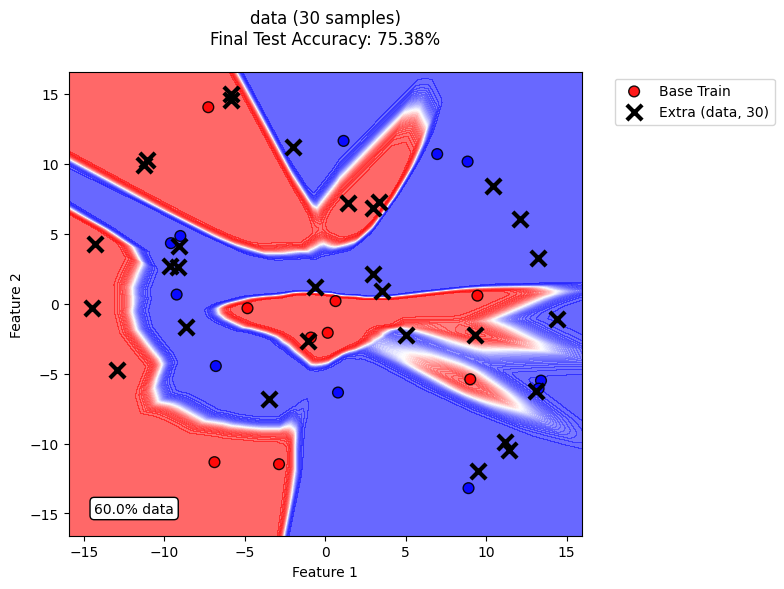

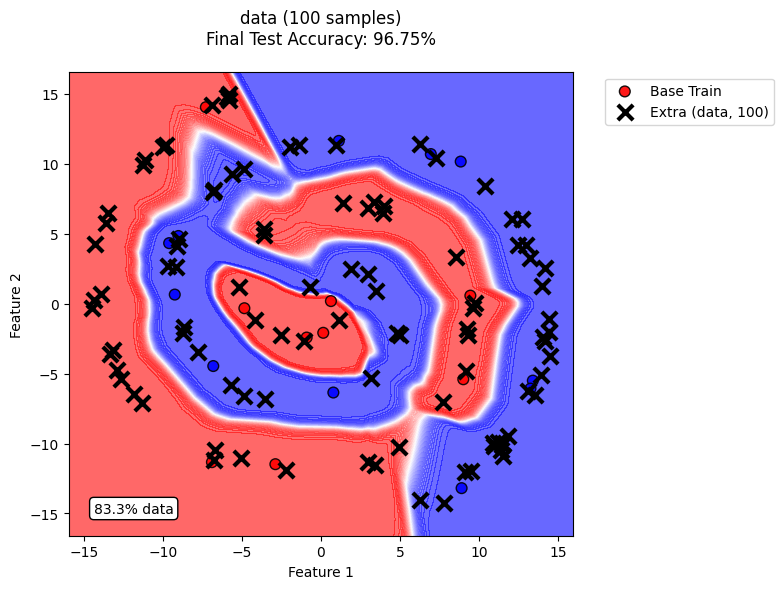

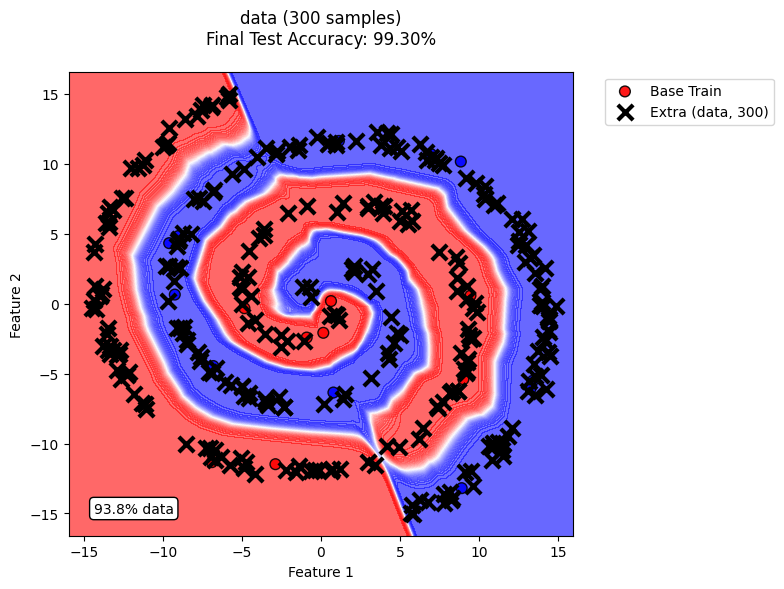

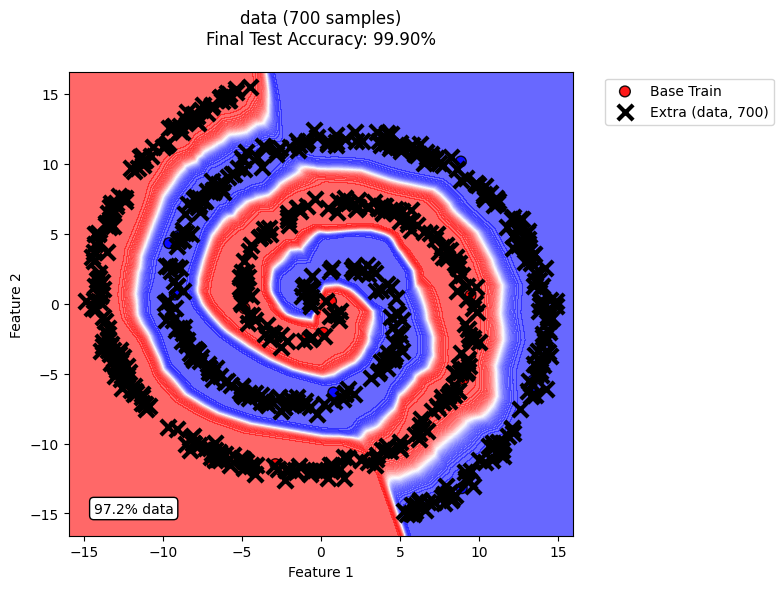

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_300.pt
Saved model: models_and_data/model_additional_300.pt
✅ Model saved to models_and_data\model_additional_700.pt
Saved model: models_and_data/model_additional_700.pt
